Shresth Grover 190820

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
import torch.nn.functional as F 
import cv2 as cv
import random

In [2]:
train_dataset = torchvision.datasets.MNIST("./",train = True, download = True)
test_dataset = torchvision.datasets.MNIST("./",train = False, download = True)

In [3]:
transform  =  transforms.Compose([
                transforms.ToTensor()])

In [4]:
train_dataset.transform = transform
test_dataset.transform = transform

In [5]:
m = len(train_dataset)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

In [6]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)


In [7]:
class VAE(nn.Module):
  def __init__(self,latent_dims):
    super(VAE,self).__init__()
    self.conv1  = nn.Conv2d(in_channels=1,out_channels=8,kernel_size=3,stride=2,padding=1)
    self.conv2  = nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,stride=2,padding=1)
    self.bn1 =  nn.BatchNorm2d(16)
    self.conv3 = nn.Conv2d(in_channels=16,out_channels = 32, kernel_size =3 ,stride = 2, padding=1 )
    self.l1  = nn.Linear(4*4*32,128)
    self.mu  = nn.Linear(128,latent_dims)
    self.sigma  = nn.Linear(128,latent_dims)
    self.N = torch.distributions.Normal(0, 1)
    self.N.loc = self.N.loc.cuda() 
    self.N.scale = self.N.scale.cuda()
    self.kl = 0

  def forward(self,x):
    x=x.cuda()
    x = F.relu(self.conv1(x))
    x = F.relu(self.bn1(self.conv2(x)))
    x = F.relu(self.conv3(x))
    x = torch.flatten(x,start_dim = 1)
    x = F.relu(self.l1(x))
    mu = self.mu(x)
    sigma = torch.exp(self.sigma(x))
    z = mu + sigma*self.N.sample(mu.shape)
    self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
    return z
    
    

In [8]:
class Decoder(nn.Module):
    
    def __init__(self, latent_dims):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x


In [9]:
class Variational_autoencoder(nn.Module):
  def __init__(self,latent_dims):
    super(Variational_autoencoder,self).__init__()
    self.encoder = VAE(latent_dims = latent_dims)
    self.decoder = Decoder(latent_dims = latent_dims)
  def forward(self,x):
    x = x.cuda()
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [10]:
torch.manual_seed(0)
d = 4
vae = Variational_autoencoder(latent_dims=d)
lr = 1e-3 
optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)
vae = vae.cuda()

In [11]:
def edge_loss(x,x_hat):
  loss = 0.0
  for i,frame in enumerate(x):
    image = frame.squeeze(0).detach().cpu().numpy()
    predicted_image = x_hat[i,:,:,:].detach().squeeze(0).cpu().numpy()
    image = image.reshape(28,28)
    predicted_image = predicted_image.reshape(28,28)
    image  = image*255
    image = image.astype(np.uint8)
    predicted_image  = predicted_image*255
    predicted_image = predicted_image.astype(np.uint8)
    pred_blur_img = cv.GaussianBlur(predicted_image,(3,3),0)
    edges = cv.Canny(image,0,100)
    predicted_edges = cv.Canny(pred_blur_img,0,100)
    edges = edges/255.0
    predicted_edges = predicted_edges/255.0
    item_loss = ((edges-predicted_edges)**2).sum()
    loss += item_loss
  return torch.tensor(loss).cuda()

In [12]:
def train_epoch(model,dataloader,optimizer,epoch,num_epochs):
  model.train()
  train_loss = 0.0
  for x,_ in dataloader:
    x = x.cuda()
    x_hat = model(x)
    epoch = min(int(.75*num_epochs),epoch)
    loss = ((x - x_hat)**2).sum() + model.encoder.kl+1/(1+(int(.75*num_epochs)-epoch))*edge_loss(x,x_hat)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss+=loss.item()

  return train_loss/len(dataloader.dataset)

In [13]:
def test_epoch(vae,dataloader):
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): 
        for x, _ in dataloader:
            x = x.cuda()
            encoded_data = vae.encoder(x)
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [14]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).cuda()
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()  


 EPOCH 1/50 	 train loss 124.428 	 val loss 71.544


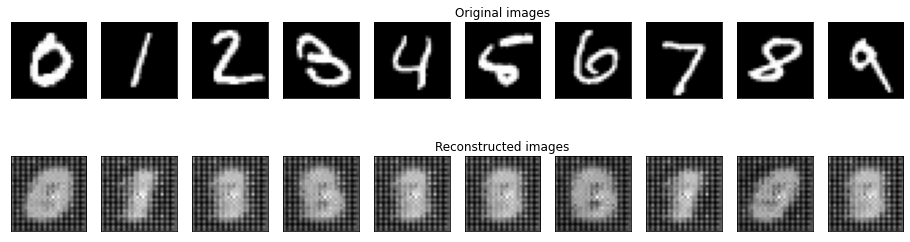


 EPOCH 2/50 	 train loss 60.049 	 val loss 47.168


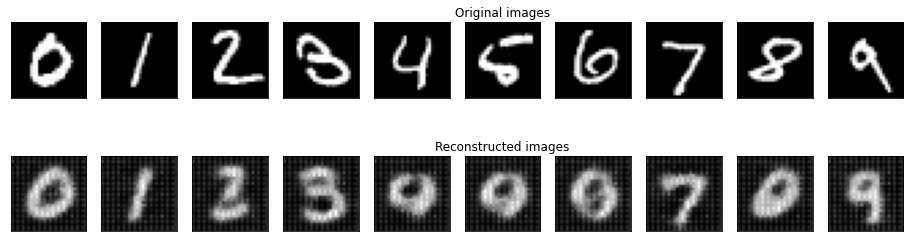


 EPOCH 3/50 	 train loss 45.177 	 val loss 39.746


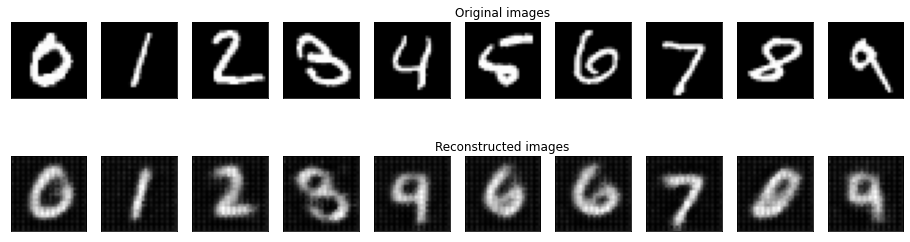


 EPOCH 4/50 	 train loss 41.063 	 val loss 37.614


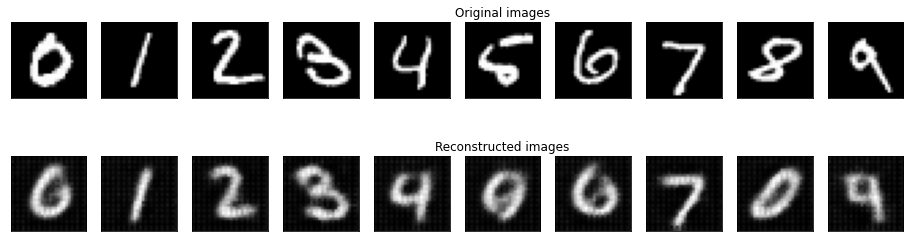


 EPOCH 5/50 	 train loss 39.467 	 val loss 36.537


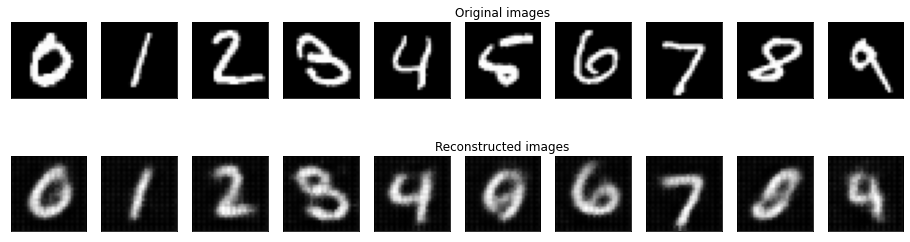


 EPOCH 6/50 	 train loss 38.604 	 val loss 35.892


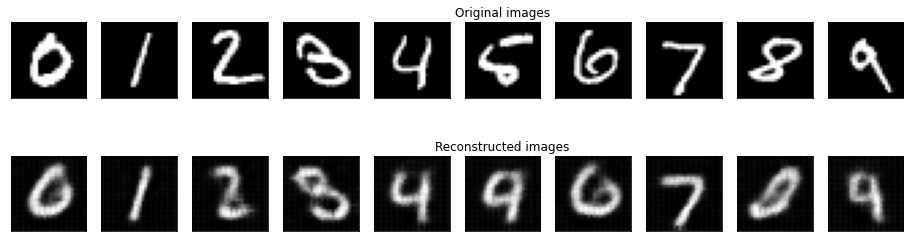


 EPOCH 7/50 	 train loss 38.056 	 val loss 35.343


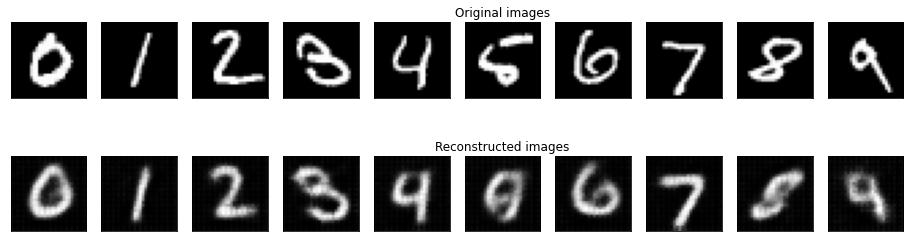


 EPOCH 8/50 	 train loss 37.728 	 val loss 34.949


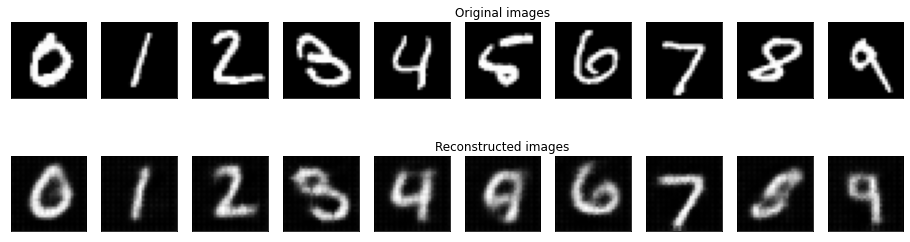


 EPOCH 9/50 	 train loss 37.473 	 val loss 34.729


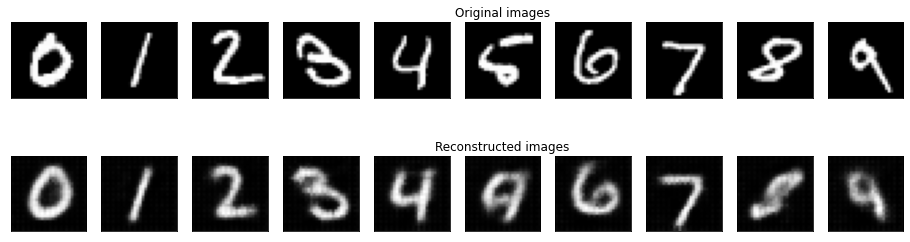


 EPOCH 10/50 	 train loss 37.272 	 val loss 34.439


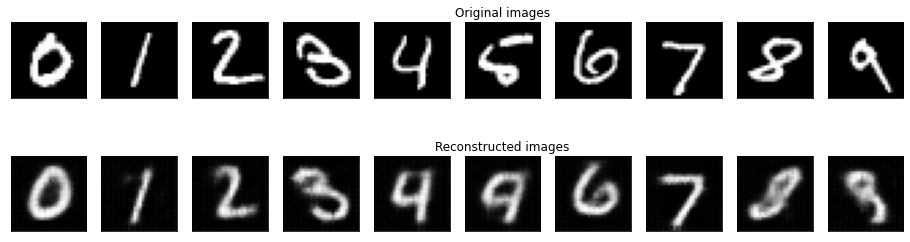


 EPOCH 11/50 	 train loss 37.188 	 val loss 34.266


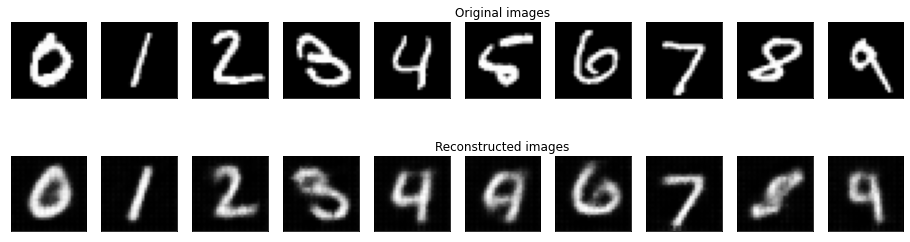


 EPOCH 12/50 	 train loss 37.085 	 val loss 34.116


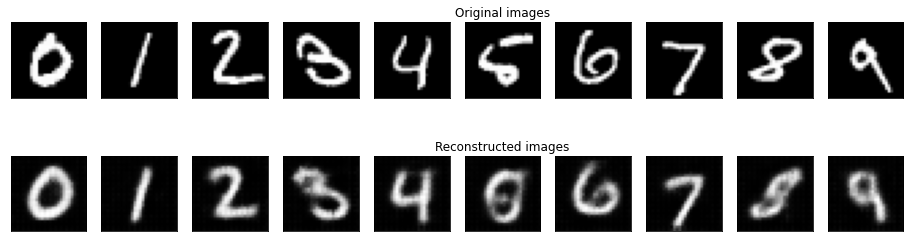


 EPOCH 13/50 	 train loss 37.052 	 val loss 33.912


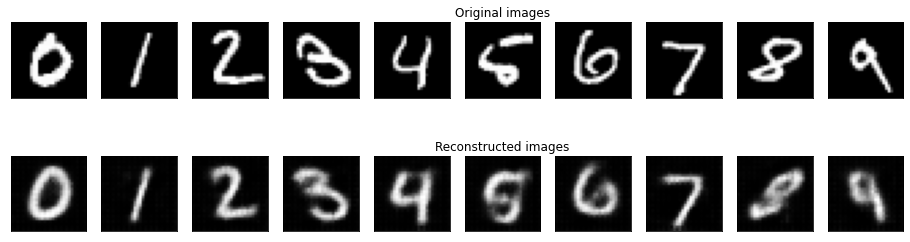


 EPOCH 14/50 	 train loss 36.992 	 val loss 33.851


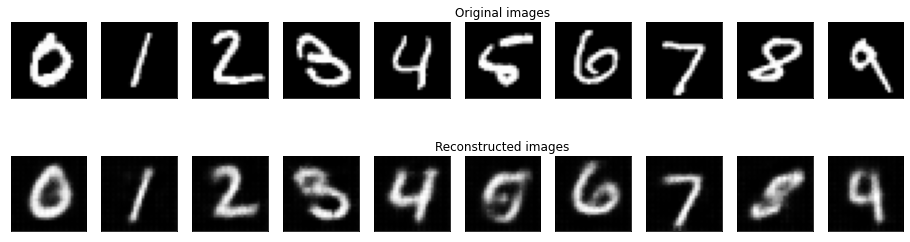


 EPOCH 15/50 	 train loss 37.047 	 val loss 33.804


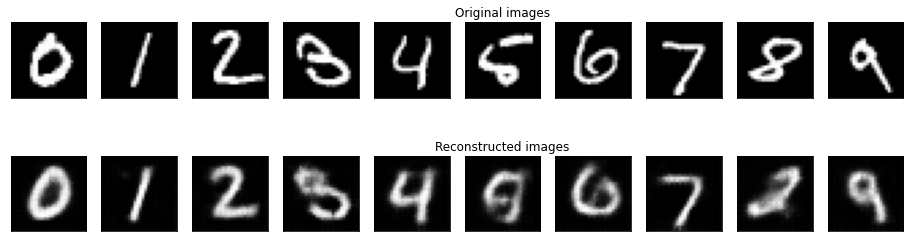


 EPOCH 16/50 	 train loss 37.066 	 val loss 33.619


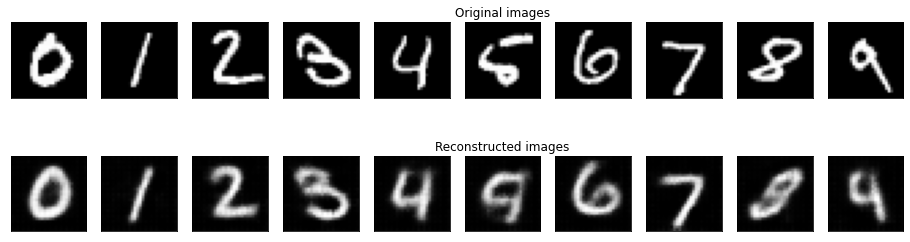


 EPOCH 17/50 	 train loss 37.060 	 val loss 33.527


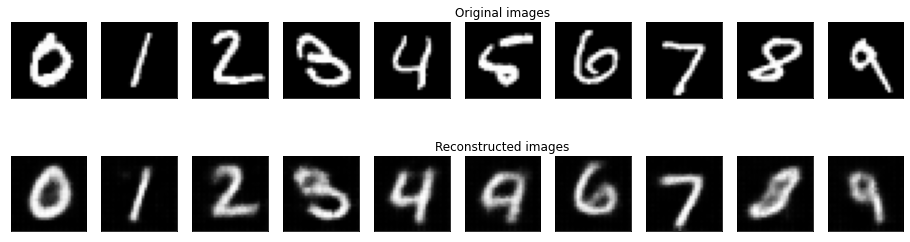


 EPOCH 18/50 	 train loss 37.184 	 val loss 33.472


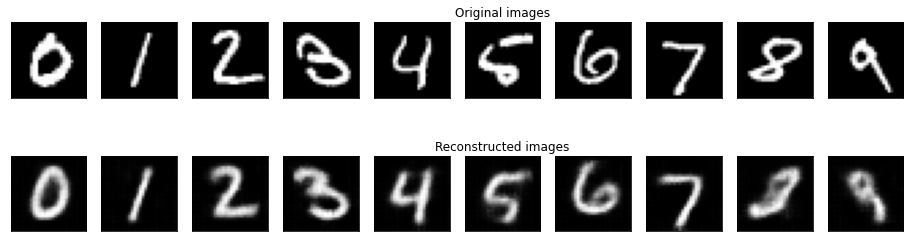


 EPOCH 19/50 	 train loss 37.281 	 val loss 33.416


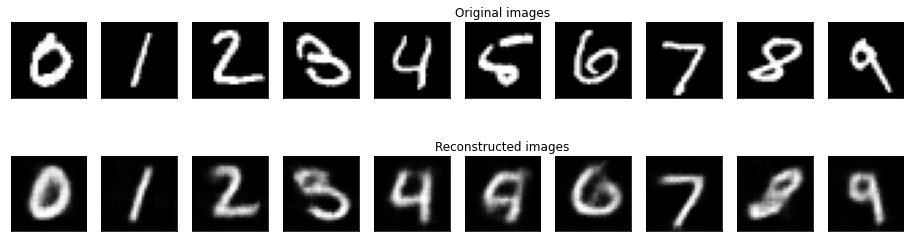


 EPOCH 20/50 	 train loss 37.415 	 val loss 33.413


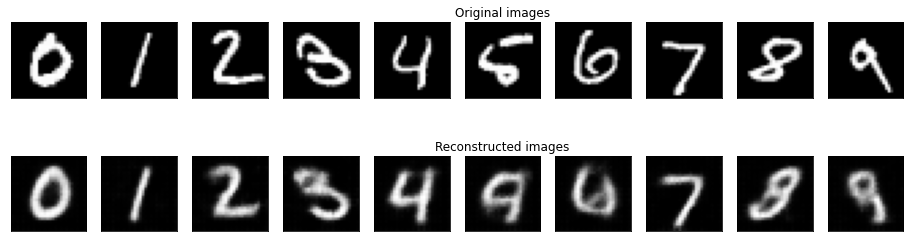


 EPOCH 21/50 	 train loss 37.577 	 val loss 33.266


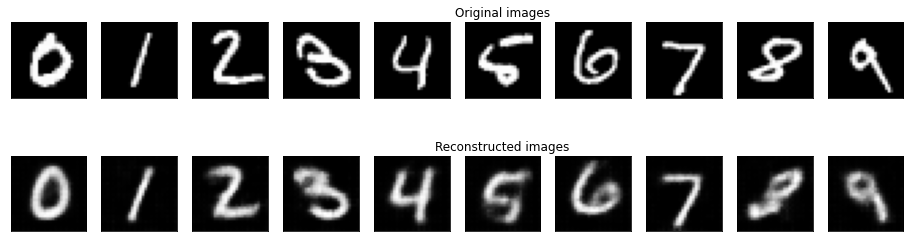


 EPOCH 22/50 	 train loss 37.779 	 val loss 33.113


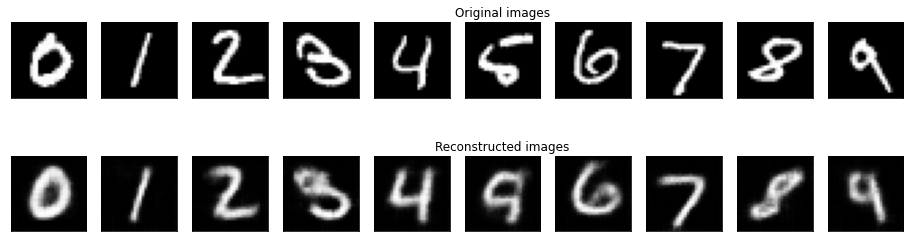


 EPOCH 23/50 	 train loss 38.004 	 val loss 33.108


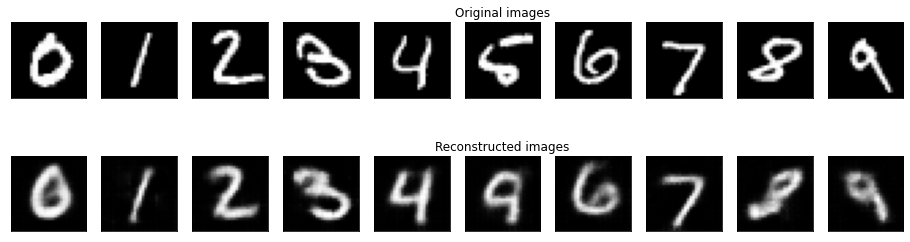


 EPOCH 24/50 	 train loss 38.259 	 val loss 33.042


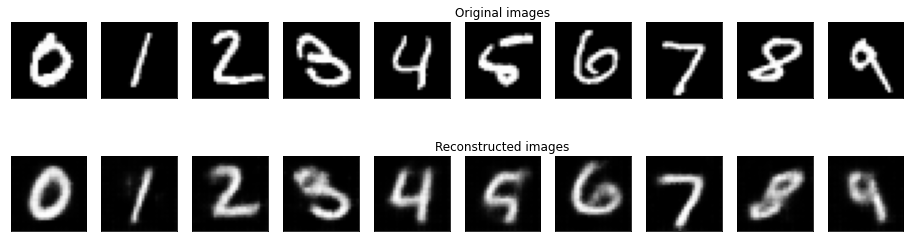


 EPOCH 25/50 	 train loss 38.605 	 val loss 32.995


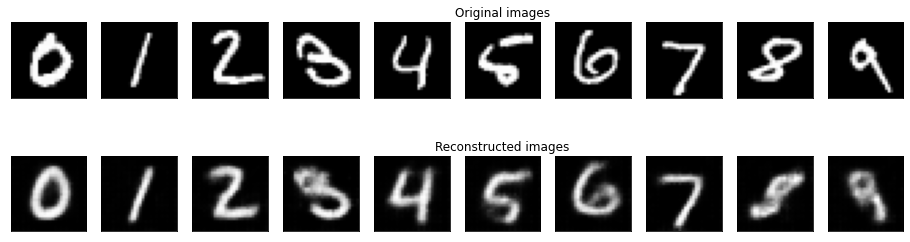


 EPOCH 26/50 	 train loss 38.985 	 val loss 32.919


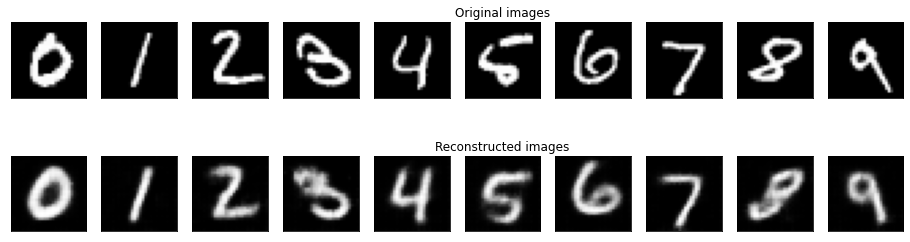

In [ ]:
num_epochs = 50

for epoch in range(num_epochs):
   train_loss = train_epoch(vae,train_loader,optim,epoch,num_epochs)
   val_loss = test_epoch(vae,valid_loader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   plot_ae_outputs(vae.encoder,vae.decoder,n=10)

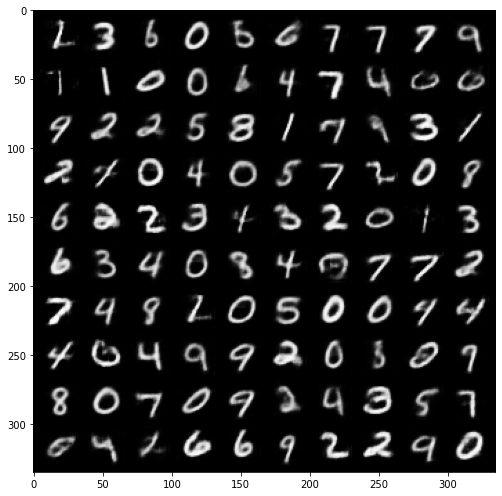

In [16]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


vae.eval()

with torch.no_grad():

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d, device="cuda")

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()